This is the given problem.

<img src="book1_img2.png">

On solving above question we recieve this posterior distribution.

<img src="book1_img1.jpg">

Our posterior distribution is proportional to g distribution. We're simply calculating g distribution but for numerical stability we are using log scale.

In [1]:
log_gdist = function(mu, n, ybar)
{
    mu2 = mu^2
    return (n*(ybar*mu - mu2/2.0) - log(1.0+mu2))
}

Now we have to write the naive implementation of metrapolis hasting algorithm.

In [2]:
metrapolis_hastings = function(n, ybar, n_iter, mu_init, cand_sd) 
{
    ## step 1, initialize
    mu_out = numeric(n_iter)
    accpt = 0
    mu_now = mu_init
    lg_now = log_gdist(mu=mu_now, n=n, ybar=ybar)

    ## step 2, iterate
    for (i in 1:n_iter) 
    {
        ## step 2a
        mu_cand = rnorm(n=1, mean=mu_now, sd=cand_sd) # draw a candidate

        ## step 2b
        lg_cand = log_gdist(mu=mu_cand, n=n, ybar=ybar) # evaluate log of g with the candidate
        lalpha = lg_cand - lg_now # log of acceptance ratio
        alpha = exp(lalpha)

        ## step 2c
        u = runif(1) # draw a uniform variable which will be less than alpha with probability min(1, alpha)
        if (u < alpha) 
        {
          # then accept the candidate
          mu_now = mu_cand
          accpt = accpt + 1 # to keep track of acceptance
          lg_now = lg_cand
        }

        ## collect results
        mu_out[i] = mu_now # save this iteration's value of mu
    }

    ## return a list of output
    list(mu=mu_out, accept_rate=accpt/n_iter)
}

Now test it with some case study

In [3]:
y = c(1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9)

In [4]:
ybar = mean(y)
n = length(y)

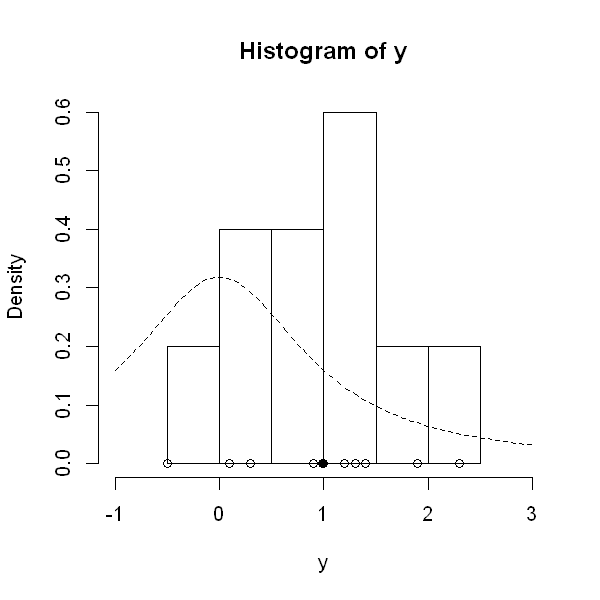

In [5]:
options(repr.plot.width = 5, repr.plot.height = 5)

hist(y, freq=FALSE, xlim=c(-1.0, 3.0)) # histogram of the data
curve(dt(x=x, df=1), lty=2, add=TRUE) # prior distribution for mu
points(y, rep(0,n), pch=1) # individual data points
points(ybar, 0, pch=19) # sample mean

In [6]:
set.seed(43) # set the random seed for reproducibility
post = metrapolis_hastings(n=n, ybar=ybar, n_iter=1e3, mu_init=0.0, cand_sd=3.0)
str(post)

List of 2
 $ mu         : num [1:1000] -0.113 1.507 1.507 1.507 1.507 ...
 $ accept_rate: num 0.122


Warning message:
"package 'coda' was built under R version 3.4.4"

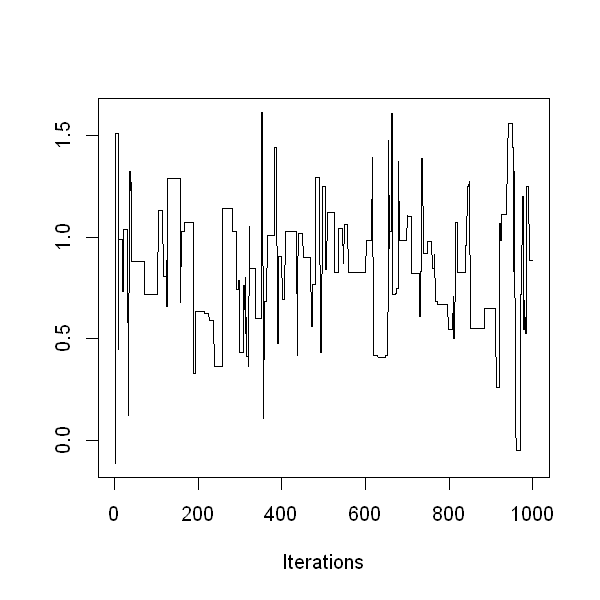

In [7]:
library("coda")
traceplot(as.mcmc(post$mu))

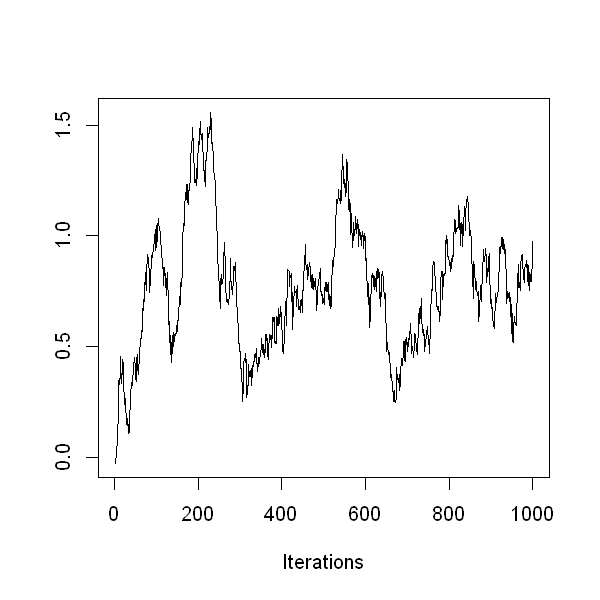

In [8]:
post = metrapolis_hastings(n=n, ybar=ybar, n_iter=1e3, mu_init=0.0, cand_sd=0.05)

traceplot(as.mcmc(post$mu))

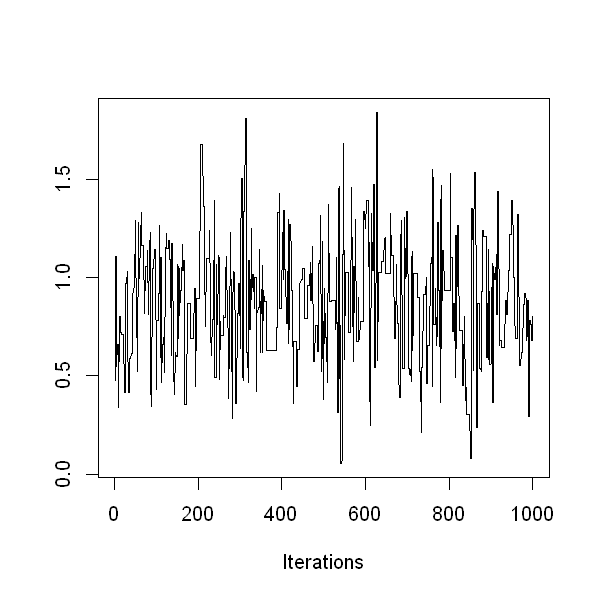

In [9]:
post = metrapolis_hastings(n=n, ybar=ybar, n_iter=1e3, mu_init=0.0, cand_sd=0.9)

traceplot(as.mcmc(post$mu))

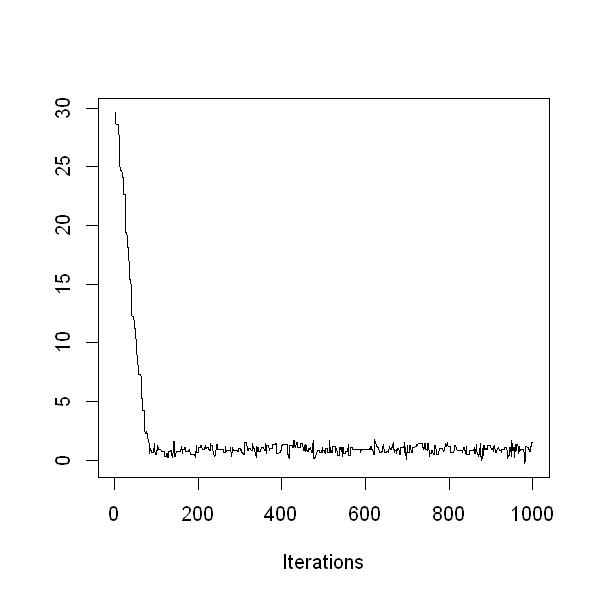

In [10]:
post = metrapolis_hastings(n=n, ybar=ybar, n_iter=1e3, mu_init=30.0, cand_sd=0.9)

traceplot(as.mcmc(post$mu))

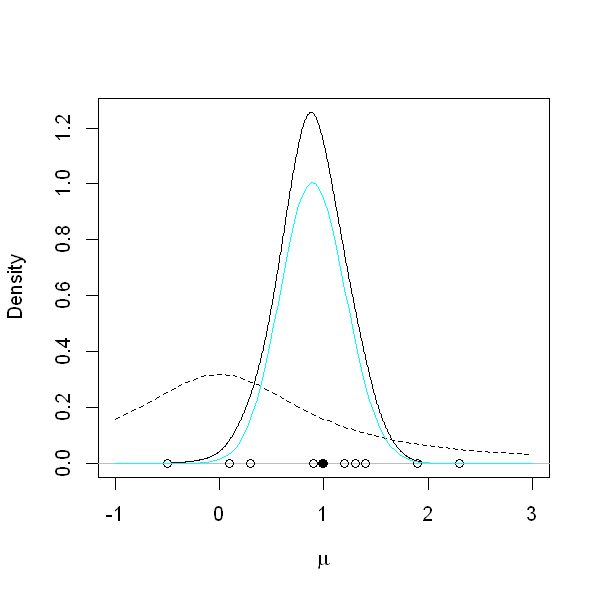

In [11]:
post$mu_keep = post$mu[-c(1:100)] # discard the first 200 samples
plot(density(post$mu_keep, adjust=2.0), main="", xlim=c(-1.0, 3.0), xlab=expression(mu)) # plot density estimate of the posterior

curve(dt(x=x, df=1), lty=2, add=TRUE) # prior distribution for mu
points(y, rep(0,n), pch=1) # individual data points
points(ybar, 0, pch=19) # sample mean

curve(0.0141*exp(log_gdist(mu=x, n=n, ybar=ybar)), from=-1.0, to=3.0, add=TRUE, col="cyan") # approximation to the true posterior in blue

In [12]:
library("ggplot2")
library("pracma") # for linspae

Warning message:
"package 'pracma' was built under R version 3.4.4"

In [13]:
x = linspace(-1.0,3.0,n)
x1 = linspace(-1.0,3.0,10000)
y1 = dt(x1, df = 1)

Warning message:
"Removed 1 rows containing missing values (geom_bar)."

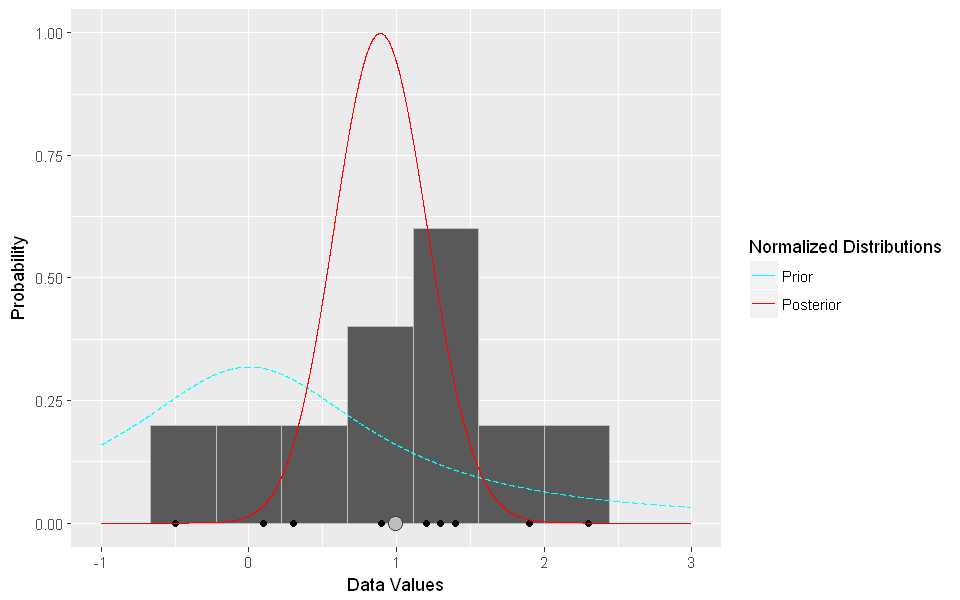

In [14]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(data=data.frame(x=x, y=y)) + 
 geom_histogram(aes(x=y, y=2*..count../sum(..count..)), bins = 10, col="gray") + 
  geom_line(data=data.frame(u=x1, v=y1), aes(x=u,y=v, color="cyan"), linetype="longdash") + 
   geom_point(x=y, y=0, colour="black", fill="black") +
    geom_point(x=ybar, y=0, shape=21, size=4, color="black", fill="gray", alpha=0.5) + 
     geom_line(data=data.frame(u=x1, v=y1), aes(x=u, y=0.0140*exp(log_gdist(mu=u, n=n, ybar=ybar)), color="red")) +
      scale_colour_manual(name="Normalized Distributions",values =c('cyan'='cyan','red'='red'), labels = c('Prior','Posterior'))+
       xlim(-1.0,3.0)+
        ylab("Probability")+
         xlab("Data Values")